<a href="https://colab.research.google.com/github/ThiwakornC/DADS6003/blob/main/Deep_Learning_today.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, DenseNet121, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import wandb
#import keras_tuner as kt
import wandb
from wandb.integration.keras import WandbCallback



In [ ]:
import shutil

checkpoint_path = "/content/dataset/.ipynb_checkpoints"

# ตรวจสอบว่ามีโฟลเดอร์อยู่จริงก่อนลบ
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)
    print("Deleted .ipynb_checkpoints successfully!")
else:
    print(".ipynb_checkpoints not found.")


.ipynb_checkpoints not found.


In [ ]:
import shutil

CHECKPOINTS_PATH = "/content/Test/.ipynb_checkpoints"

# ถ้ามีโฟลเดอร์นี้อยู่ ให้ลบทิ้งเลย
if os.path.exists(CHECKPOINTS_PATH):
    shutil.rmtree(CHECKPOINTS_PATH)
    print("✅ ลบ .ipynb_checkpoints สำเร็จ!")
else:
    print("🔍 ไม่พบ .ipynb_checkpoints ใน Test Set")


🔍 ไม่พบ .ipynb_checkpoints ใน Test Set


In [ ]:
!pip install wandb --upgrade

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, DenseNet121, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/Colab Drives/Dataset/train"  # Train dataset path
validation_path = "/content/drive/MyDrive/Colab Drives/Dataset/validation"  # >>> Validation dataset path
test_path = "/content/drive/MyDrive/Colab Drives/Dataset/test"  # >>> Test dataset path

classes = ["basketball", "training", "futsal", "running"]

In [ ]:
# Part 1 : Dataset description

In [ ]:
import os
import pandas as pd

# Exploratory Data Analysis (EDA)
def get_class_counts(data_path, dataset_type="Train"):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[f"{class_name} ({dataset_type})"] = num_images
        else:
            class_counts[f"{class_name} ({dataset_type})"] = 0  # If class folder is missing
    return class_counts

# Get counts for both train and validation datasets
train_counts = get_class_counts(train_path, "Train")
val_counts = get_class_counts(validation_path, "Validation")
test_counts = get_class_counts(test_path, "Test")

# Combine results into a DataFrame
df_counts = pd.DataFrame(list(train_counts.items()) + list(val_counts.items()) + list(test_counts.items()), columns=["Class", "Number of Images"])

# Print dataset distribution
print(df_counts)


                      Class  Number of Images
0        basketball (Train)                55
1          training (Train)                55
2            futsal (Train)                60
3           running (Train)                60
4   basketball (Validation)                18
5     training (Validation)                18
6       futsal (Validation)                20
7      running (Validation)                20
8         basketball (Test)                18
9           training (Test)                18
10            futsal (Test)                20
11           running (Test)                20


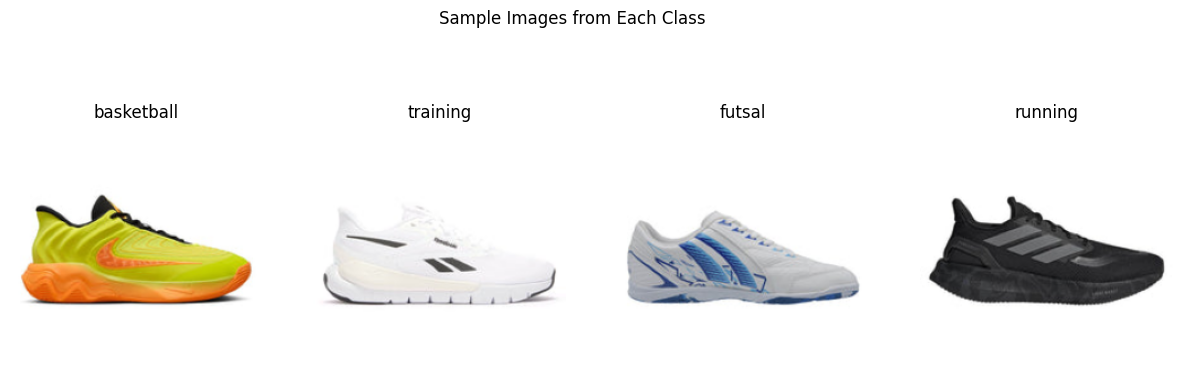

In [ ]:
# แสดงตัวอย่างภาพจาก dataset

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, class_name in enumerate(classes):
    class_path = os.path.join(train_path, class_name)
    sample_image = random.choice(os.listdir(class_path))
    img = cv2.imread(os.path.join(class_path, sample_image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize for visualization

    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()


<ipython-input-15-6229e40da46e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_counts["Class"], y=df_counts["Number of Images"], palette="viridis")


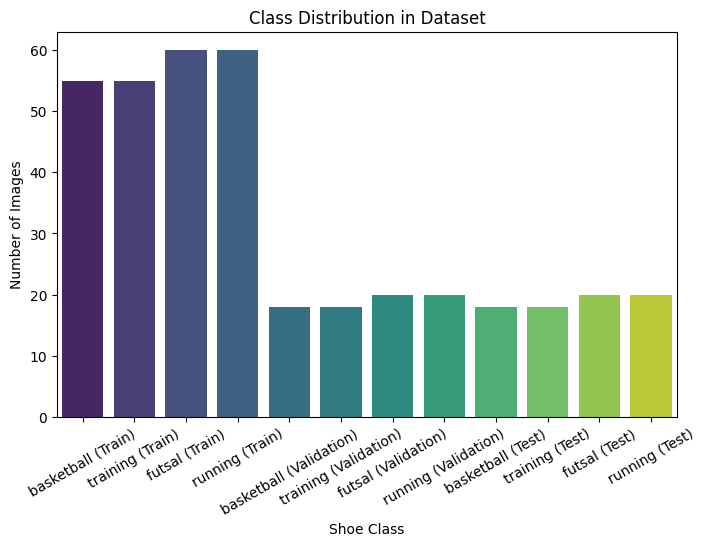

In [ ]:
# ตรวจสอบความไม่สมดุลของ dataset (Imbalance Analysis)

import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=df_counts["Class"], y=df_counts["Number of Images"], palette="viridis")
plt.xlabel("Shoe Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=30)
plt.show()


In [ ]:
# Calculate min, max, and imbalance ratio for each dataset
def analyze_dataset_balance(class_counts, dataset_type="Dataset"):
    if not class_counts:  # Handle empty datasets
        print(f"⚠️ No data found in {dataset_type}.")
        return

    min_class = min(class_counts.values())  # Smallest class size
    max_class = max(class_counts.values())  # Largest class size
    imbalance_ratio = max_class / max(1, min_class)  # Avoid division by zero

    print(f"\n📊 {dataset_type} Analysis:")
    print(f"   Min class size: {min_class}, Max class size: {max_class}")
    print(f"   Imbalance Ratio: {imbalance_ratio:.2f}")

    if imbalance_ratio > 1.5:
        print("   ⚠️ Warning: Dataset is imbalanced. Consider using data augmentation or resampling techniques.")
    else:
        print("   ✅ Dataset looks balanced.")

# Get class counts for train, validation, and test datasets
train_counts = get_class_counts(train_path, "Train")
val_counts = get_class_counts(validation_path, "Validation")
test_counts = get_class_counts(test_path, "Test")

# Analyze balance for each dataset
analyze_dataset_balance(train_counts, "Train Dataset")
analyze_dataset_balance(val_counts, "Validation Dataset")
analyze_dataset_balance(test_counts, "Test Dataset")



📊 Train Dataset Analysis:
   Min class size: 55, Max class size: 60
   Imbalance Ratio: 1.09
   ✅ Dataset looks balanced.

📊 Validation Dataset Analysis:
   Min class size: 18, Max class size: 20
   Imbalance Ratio: 1.11
   ✅ Dataset looks balanced.

📊 Test Dataset Analysis:
   Min class size: 18, Max class size: 20
   Imbalance Ratio: 1.11
   ✅ Dataset looks balanced.


In [ ]:
#Part 2: Data Preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# กำหนดค่าขนาดภาพมาตรฐาน
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# ฟังก์ชันเตรียมข้อมูล (resize + normalize)
def preprocess_image(image):
    image = tf.image.resize(image, IMAGE_SIZE)  # Resize รูปเป็น 224x224
    image = image / 255.0  # Normalize ค่าให้เป็นช่วง [0,1]
    return image


In [ ]:
# กำหนดพาธของ dataset
#DATASET_PATH = "/content/dataset"

# ใช้ ImageDataGenerator แบ่งชุดข้อมูล
train_datagen = ImageDataGenerator(rescale=1./255)
#train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)  # 80% train, 20% validation

# Train set (60%)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    #subset='training'  # 80% จาก train set
)

# Validation set (20%)
val_generator = train_datagen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    #subset='validation'  # 20% จาก train set
)

# Test set (20%) → ใช้โฟลเดอร์แยก
TEST_PATH = test_path
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# แสดงจำนวนรูปในแต่ละชุด
print(f"✅ Train set size: {train_generator.samples} images")
print(f"✅ Validation set size: {val_generator.samples} images")
print(f"✅ Test set size: {test_generator.samples} images")


Found 230 images belonging to 4 classes.
Found 76 images belonging to 4 classes.
Found 76 images belonging to 4 classes.
✅ Train set size: 230 images
✅ Validation set size: 76 images
✅ Test set size: 76 images


In [ ]:
# 3. Data Augmentation (เสริมความหลากหลายให้ข้อมูล)

# Augmentation สำหรับ Train Set
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,         # หมุนภาพไม่เกิน 40 องศา (เพิ่มขึ้นเล็กน้อย)
    width_shift_range=0.15,    # ขยับภาพแนวนอนไม่เกิน 25%
    height_shift_range=0.15,   # ขยับภาพแนวตั้งไม่เกิน 25%
    shear_range=0.2,           # เพิ่มการบิดภาพเล็กน้อย (shear)
    zoom_range=0.2,            # ซูมเข้า-ออกไม่เกิน 30% (เพิ่มขึ้น)
    brightness_range=[0.7, 1.3], # ปรับความสว่างระหว่าง 70% - 130%
    horizontal_flip=True,      # กลับด้านแนวนอน
    fill_mode='nearest',       # เติมส่วนที่ขาดหายไปของภาพ
    #validation_split=0.20      # ใช้ validation set 20%
)

# สร้าง Train Set ใหม่ที่มี Augmentation
train_aug_generator = train_aug_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    #subset='training'  # 80% จาก train set
)


Found 230 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


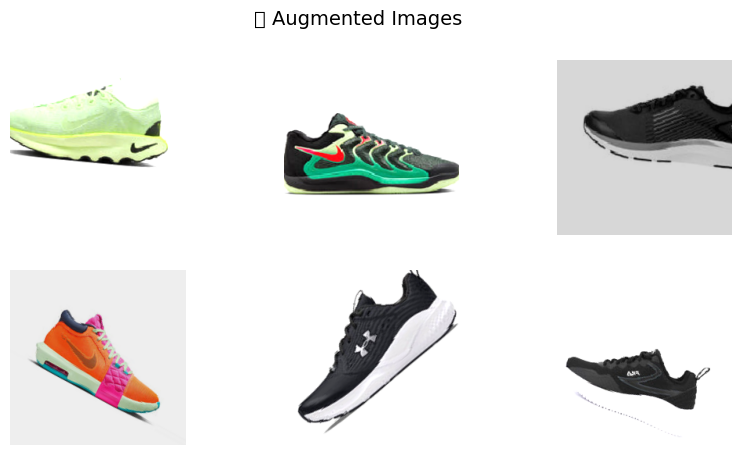

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ดึงรูปจาก Train Generator ที่มี Augmentation
sample_images, _ = next(train_aug_generator)

# แสดง 6 ตัวอย่าง
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.axis("off")
plt.suptitle("🔍 Augmented Images", fontsize=14)
plt.show()


In [ ]:
# 3. Model architecture

Found classes: ['basketball', 'futsal', 'running', 'training']
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
DenseNet121 - basketball: image_62.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
MobileNetV2 - basketball: image_62.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
ResNet50 - basketball: image_62.jpg -> Predicted: running_shoe


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
VGG16 - basketball: image_62.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
DenseNet121 - futsal: image_73.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MobileNetV2 - futsal: image_73.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ResNet50 - futsal: image_73.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
VGG16 - futsal: image_73.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
DenseNet121 - running: image_478.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MobileNetV2 - running: image_478.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ResNet50 - running: image_478.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
VGG16 - running: image_478.jpg -> Predicted: running_shoe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
DenseNet121 - training: image_1.jpg -> Predicted: running_shoe
1/1 ━━━━━━

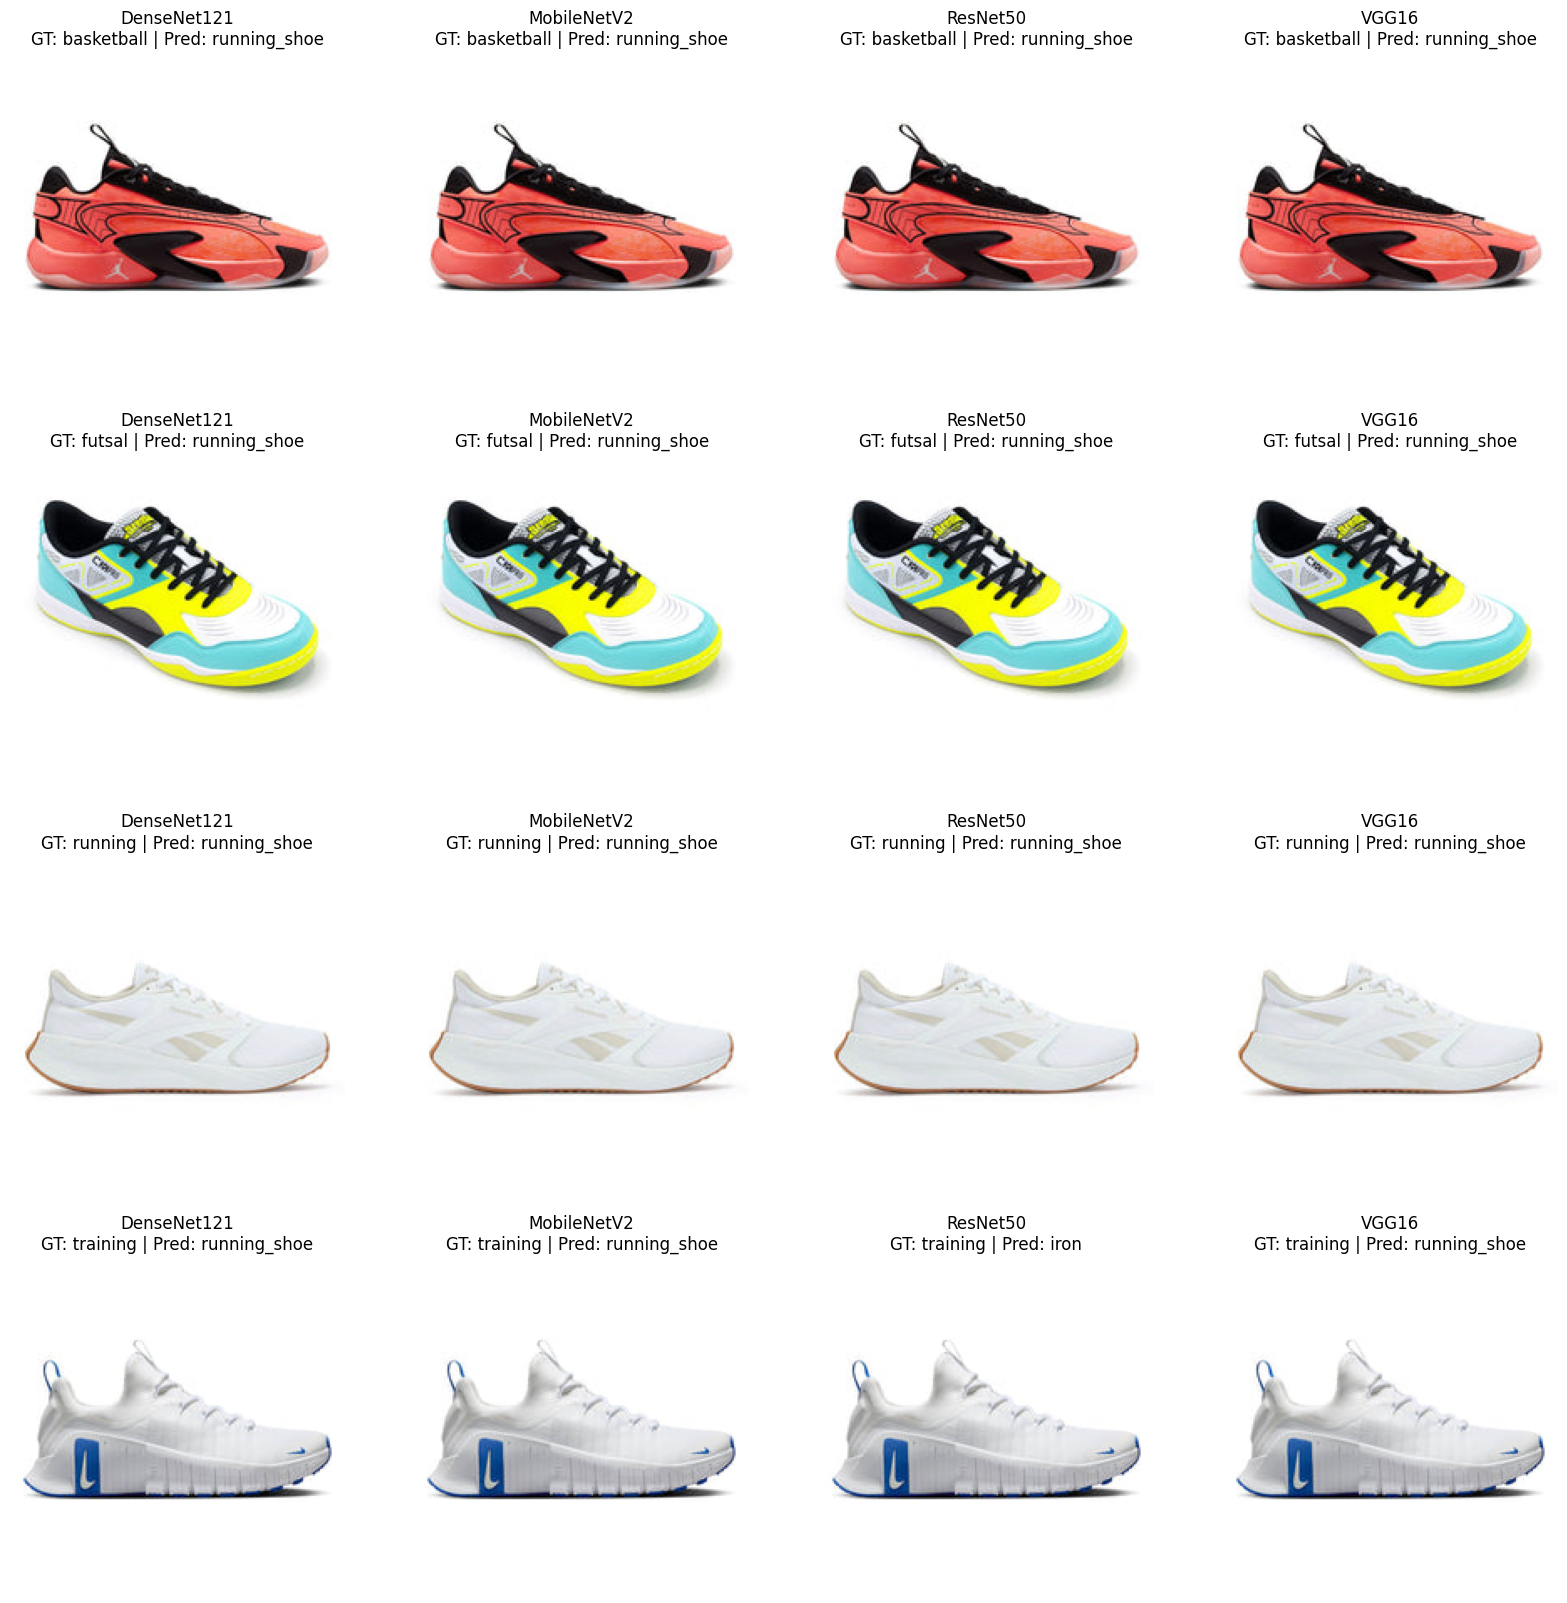

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications import DenseNet121, MobileNetV2, ResNet50, VGG16
from tensorflow.keras.applications.densenet import preprocess_input as densenet121_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess



# ------------------------------
# โหลดโมเดลพรีเทรน (ยังไม่ทำ Fine-tune)
# ------------------------------
models = {
    "DenseNet121": DenseNet121(weights="imagenet"),
    "MobileNetV2": MobileNetV2(weights="imagenet"),
    "ResNet50": ResNet50(weights="imagenet"),
    "VGG16": VGG16(weights="imagenet"),
}

# ฟังก์ชัน Preprocessing ตามโมเดลที่เลือก
preprocess_functions = {
    "DenseNet121": densenet121_preprocess,
    "MobileNetV2": mobilenet_preprocess,
    "ResNet50": resnet_preprocess,
    "VGG16": vgg_preprocess,
}

# ------------------------------
# กำหนด path ของโฟลเดอร์ที่เก็บภาพทดสอบ
# ------------------------------
test_folder = test_path

# อ่านรายชื่อคลาสที่มีอยู่ในโฟลเดอร์
classes = sorted(os.listdir(test_folder))
print(f"Found classes: {classes}")

# ------------------------------
# ฟังก์ชันสุ่มเลือกรูปจากแต่ละคลาส
# ------------------------------
def get_random_image(class_name):
    class_path = os.path.join(test_folder, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    if not image_files:
        return None, None
    random_image = random.choice(image_files)
    return os.path.join(class_path, random_image), random_image

# ------------------------------
# ฟังก์ชันทำนาย class โดยโมเดลพรีเทรน
# ------------------------------
def predict_class(image_path, model_name):
    model = models[model_name]
    preprocess_func = preprocess_functions[model_name]

    try:
        img = cv2.imread(image_path)
        if img is None:
            return "Error: Image not found"

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = preprocess_func(img)
        img = np.expand_dims(img, axis=0)

        preds = model.predict(img)
        decoded_preds = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=1)[0][0][1]
        return decoded_preds
    except Exception as e:
        return f"Error: {str(e)}"

# ------------------------------
# ทดสอบโมเดลโดยไม่ fine-tune และเก็บผลลัพธ์ใน DataFrame
# ------------------------------
results = []
fig, axes = plt.subplots(len(classes), len(models), figsize=(20, 5 * len(classes)))

for i, class_name in enumerate(classes):
    image_path, image_name = get_random_image(class_name)
    if image_path and os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for j, model_name in enumerate(models.keys()):
            pred_class = predict_class(image_path, model_name)

            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{model_name}\nGT: {class_name} | Pred: {pred_class}")
            axes[i, j].axis("off")

            # บันทึกผลลัพธ์เป็นตาราง
            results.append({"Model": model_name, "GT Class": class_name, "Image": image_name, "Predicted": pred_class})
            print(f"{model_name} - {class_name}: {image_name} -> Predicted: {pred_class}")
    else:
        for j in range(len(models)):
            axes[i, j].text(0.5, 0.5, "No Image", fontsize=12, ha='center')
            axes[i, j].set_title(classes[i])
            axes[i, j].axis("off")

plt.show()

# ------------------------------
# แสดงผลเป็น DataFrame
# ------------------------------
df_results = pd.DataFrame(results)
from google.colab import data_table
data_table.DataTable(df_results)


In [ ]:
# 4.Training method

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2  # ใช้ L2 Regularization

# ฟังก์ชันสร้างโมเดล (เลือก Backbone และกำหนด output ใหม่)
def create_model(base_model_name, num_classes=4):
    if base_model_name == "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False)
    elif base_model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False)
    elif base_model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False)
    elif base_model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
    else:
        raise ValueError("Invalid model name")

    # Freeze น้ำหนักของ Backbone
    base_model.trainable = False

    # เพิ่ม Fully Connected Layer ใหม่ พร้อม L2 Regularization
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)  # L2 Regularization
    x = Dropout(0.30000000000000004)(x)  # Dropout ช่วยลด Overfitting
    output = Dense(num_classes, activation="softmax")(x)

    # รวม Backbone + Fully Connected Layers
    model = Model(inputs=base_model.input, outputs=output)
    return model

# ทดสอบสร้างโมเดล
model = create_model("DenseNet121")
model.summary()  # ตรวจสอบโครงสร้าง


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_8          │ (None, None, None, 3)  │              0 │ input_layer_13[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,408 │ zero_padding2d_8[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_9          │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, None, None, 64) │              0 │ zero_padding2d_9[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, None, None, 64) │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, None, None, 64) │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None,     │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None,     │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None,     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 32) │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, None, None, 96) │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# กำหนด Optimizer, Loss Function และ Metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # 🔧 Learning Rate เล็กเพื่อให้เรียนรู้ดีขึ้น
loss_fn = tf.keras.losses.CategoricalCrossentropy()
metrics = ["accuracy"]

# คอมไพล์โมเดล
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)



Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 174s 20s/step - accuracy: 0.3183 - loss: 8.4892 - val_accuracy: 0.3026 - val_loss: 8.0614
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.2826 - loss: 8.0978 - val_accuracy: 0.4737 - val_loss: 7.8001
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.4170 - loss: 7.6667 - val_accuracy: 0.4605 - val_loss: 7.5587
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.4836 - loss: 7.5040 - val_accuracy: 0.4737 - val_loss: 7.3501
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.5290 - loss: 7.2299 - val_accuracy: 0.5395 - val_loss: 7.1461
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.6016 - loss: 7.0250 - val_accuracy: 0.5658 - val_loss: 6.9462
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.6381 - loss: 6.8099 - val_accuracy: 0.6579 - val_loss: 6.7643
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.6293 - loss: 6.6614 - val_accuracy: 0.6447 - val_loss:

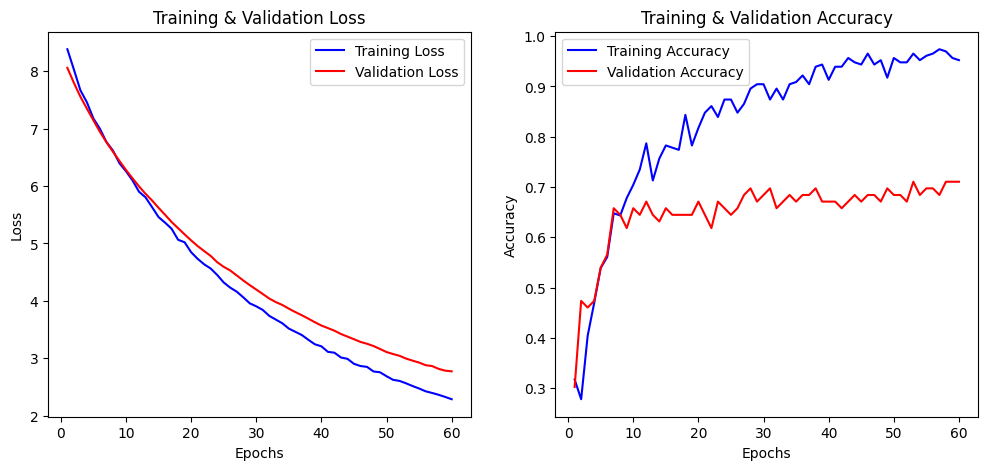

In [ ]:
import matplotlib.pyplot as plt
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# ✅ เริ่ม WandB ด้วยชื่อ entity ที่ถูกต้อง
wandb.init(project="shoe-classification", entity="napateek-nida-business-school", config={
    "learning_rate": 0.0001,
    "epochs": 60,
    "batch_size": 32
})

# ตั้งค่าคอนฟิกจาก WandB
config = wandb.config

# ✅ ใช้ Callback ที่ใหม่กว่า
wandb_callbacks = [
    WandbMetricsLogger(),  # 📊 Log Metrics เช่น loss, accuracy
    WandbModelCheckpoint(filepath="best_model.keras", monitor="val_loss", save_best_only=True)  # ✅ Save Best Model
]

# ✅ Train Model พร้อม Callback ของ WandB
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs= 60,
    batch_size=config.batch_size,
    callbacks=wandb_callbacks  # ✅ ใช้ Callback ที่ถูกต้อง
)

# --------------------------
# ✅ แสดงผลลัพธ์ของการ Training
# --------------------------

# ดึงค่า loss และ accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# ✅ Plot กราฟ Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ✅ Plot กราฟ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# ✅ แสดงผลลัพธ์
plt.show()


In [ ]:
import pandas as pd

# แสดงจำนวนรูปภาพในแต่ละชุด
df_summary = pd.DataFrame({
    "Dataset Split": ["Train", "Validation", "Test"],
    "Number of Images": [train_generator.samples, val_generator.samples, test_generator.samples]
})

print(df_summary)

  Dataset Split  Number of Images
0         Train               230
1    Validation                76
2          Test                76


In [ ]:
# 5. Evaluation metrics

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step
              precision    recall  f1-score   support

  basketball       0.92      0.61      0.73        18
      futsal       0.91      1.00      0.95        20
     running       0.70      0.80      0.74        20
    training       0.63      0.67      0.65        18

    accuracy                           0.78        76
   macro avg       0.79      0.77      0.77        76
weighted avg       0.79      0.78      0.77        76



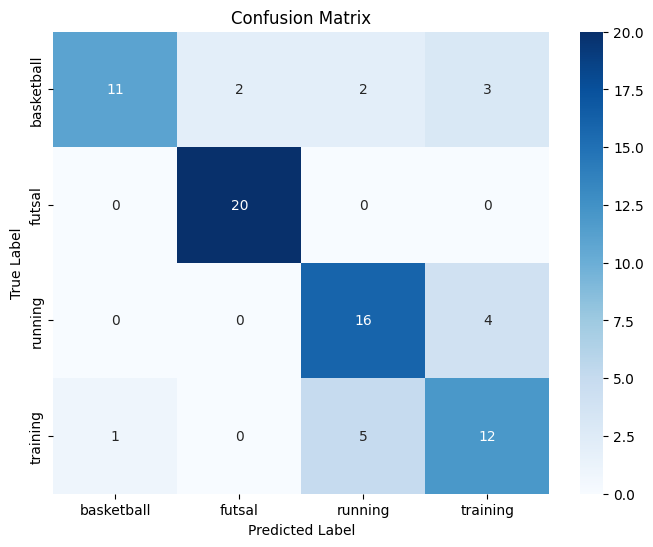

In [ ]:
# โค้ดสำหรับวัดผล Accuracy, Precision, Recall และ F1-score

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ ใช้โมเดลทำนายบน Test Set
y_true = test_generator.classes  # Ground Truth Labels
y_pred_probs = model.predict(test_generator)  # Prediction Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงผลลัพธ์เป็นคลาสที่โมเดลทำนาย

# ✅ แสดงรายงานผลลัพธ์ของแต่ละคลาส (Precision, Recall, F1-score)
class_labels = list(test_generator.class_indices.keys())  # รายชื่อคลาส
print(classification_report(y_true, y_pred, target_names=class_labels))

# ✅ แสดง Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 6. Experimental results

In [ ]:
#######################################################
# SECTION 1: Import Libraries & Global Settings
#######################################################
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

# ✅ กำหนด Random Seed เพื่อให้ผลลัพธ์สม่ำเสมอ
SEED = 789
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ตั้งค่าแสดงผล Pandas ให้สวยขึ้น
pd.set_option("display.precision", 4)
pd.set_option("display.width", 1000)

#######################################################
# SECTION 2: Prepare Dataset (Data Generators)
#######################################################
#DATASET_PATH = "/content/dataset"
TEST_PATH    = test_path
NUM_CLASSES  = 4

train_datagen = ImageDataGenerator(rescale=1./255)#, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    #subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    #subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

#######################################################
# SECTION 3: Callback สำหรับจับเวลาในแต่ละ Epoch
#######################################################
class TimeHistory(Callback):
    """
    Callback สำหรับจับเวลาในแต่ละ epoch
    """
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)

#######################################################
# SECTION 4: Function สร้างโมเดล (With Fine-Tuning & L2 Regularization)
#######################################################
def create_model(model_name, num_classes=4, fine_tune=True):
    if model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet", include_top=False)
    elif model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False)
    elif model_name == "DenseNet121":
        base_model = DenseNet121(weights="imagenet", include_top=False)
    elif model_name == "VGG16":
        base_model = VGG16(weights="imagenet", include_top=False)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Fine-tuning: Unfreeze Layers บางส่วน

    # ✅ Freeze ทุก Layer (ไม่ให้เรียนรู้ต่อ)
    base_model.trainable = False  # ❌ ไม่ให้ Backbone อัปเดตน้ำหนัก

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)  # ✅ L2 Regularization
    x = Dropout(0.1)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

#######################################################
# SECTION 5: Train & Fine-Tune Models
#######################################################
model_names = ["DenseNet121", "MobileNetV2", "ResNet50", "VGG16"]
num_runs = 5
num_epochs = 25
learning_rate = 1e-4

all_results = {model: [] for model in model_names}

for model_name in model_names:
    for run in range(num_runs):
        print(f"\n===== Training Model: {model_name} (Run {run+1}) =====")
        tf.keras.backend.clear_session()

        model = create_model(model_name, num_classes=NUM_CLASSES, fine_tune=True)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        time_callback = TimeHistory()

        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=num_epochs,
            callbacks=[time_callback],
            verbose=1
        )

        epoch_times = time_callback.epoch_times
        avg_time_per_epoch = np.mean(epoch_times)

        test_start = time.time()
        y_pred = model.predict(test_generator)
        test_time = time.time() - test_start

        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.classes

        report = classification_report(y_true, y_pred_classes, output_dict=True)
        accuracy = report["accuracy"]
        precision = np.mean([report[str(cls)]["precision"] for cls in np.unique(y_true)])
        recall    = np.mean([report[str(cls)]["recall"] for cls in np.unique(y_true)])
        f1_score  = np.mean([report[str(cls)]["f1-score"] for cls in np.unique(y_true)])

        all_results[model_name].append({
            "history": history.history,
            "avg_epoch_time_sec": avg_time_per_epoch,
            "test_inference_time_sec": test_time,
            "y_true": y_true,
            "y_pred_classes": y_pred_classes,
            "metrics": {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score
            }
        })




Found 230 images belonging to 4 classes.
Found 76 images belonging to 4 classes.
Found 76 images belonging to 4 classes.

===== Training Model: DenseNet121 (Run 1) =====


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.2847 - loss: 2.2929 - val_accuracy: 0.3684 - val_loss: 2.0154
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.3883 - loss: 2.0289 - val_accuracy: 0.4737 - val_loss: 1.9187
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4872 - loss: 1.8966 - val_accuracy: 0.5658 - val_loss: 1.7919
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5631 - loss: 1.7429 - val_accuracy: 0.5526 - val_loss: 1.7095
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5973 - loss: 1.6227 - val_accuracy: 0.6316 - val_loss: 1.6442
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6878 - loss: 1.5789 - val_accuracy: 0.6842 - val_loss: 1.5827
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6608 - loss: 1.5149 - val_accuracy: 0.6184 - val_loss: 1.5386
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7144 - loss: 1.4483 - val_accuracy: 0.6579 - val_loss: 1

<ipython-input-39-ad8b44ce5170>:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3339 - loss: 2.2216 - val_accuracy: 0.3553 - val_loss: 2.0729
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4100 - loss: 1.9318 - val_accuracy: 0.5395 - val_loss: 1.9061
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6660 - loss: 1.7541 - val_accuracy: 0.6316 - val_loss: 1.7938
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7347 - loss: 1.5959 - val_accuracy: 0.6579 - val_loss: 1.7113
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7977 - loss: 1.4650 - val_accuracy: 0.6711 - val_loss: 1.6568
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7814 - loss: 1.4410 - val_accuracy: 0.6842 - val_loss: 1.5918
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8250 - loss: 1.3946 - val_accuracy: 0.6974 - val_loss: 1.5499
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8358 - 

<ipython-input-39-ad8b44ce5170>:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False)


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2194 - loss: 2.2701 - val_accuracy: 0.3684 - val_loss: 2.0046
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4372 - loss: 1.9732 - val_accuracy: 0.5789 - val_loss: 1.8355
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.6389 - loss: 1.7601 - val_accuracy: 0.6316 - val_loss: 1.7414
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6835 - loss: 1.6384 - val_accuracy: 0.7237 - val_loss: 1.6372
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7918 - loss: 1.5785 - val_accuracy: 0.7368 - val_loss: 1.5686
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8095 - loss: 1.4532 - val_accuracy: 0.7632 - val_loss: 1.5279
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8108 - loss: 1.3824 - val_accuracy: 0.7895 - val_loss: 1.4837
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8510 - loss: 1.3264 - val_accuracy: 0.7763 - val_loss: 1

<ipython-input-39-ad8b44ce5170>:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False)


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2338 - loss: 2.3028 - val_accuracy: 0.5132 - val_loss: 1.9517
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3481 - loss: 2.0064 - val_accuracy: 0.5263 - val_loss: 1.8215
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5364 - loss: 1.7849 - val_accuracy: 0.6579 - val_loss: 1.7170
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6025 - loss: 1.7135 - val_accuracy: 0.6579 - val_loss: 1.6439
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6848 - loss: 1.6136 - val_accuracy: 0.6711 - val_loss: 1.5913
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.7915 - loss: 1.4560 - val_accuracy: 0.7105 - val_loss: 1.5444
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8321 - loss: 1.3682 - val_accuracy: 0.7105 - val_loss: 1.5088
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8404 - loss: 1.3203 - val_accuracy: 0.7105 - val_loss: 1

<ipython-input-39-ad8b44ce5170>:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False)


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3023 - loss: 2.1418 - val_accuracy: 0.4342 - val_loss: 1.9746
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5166 - loss: 1.8978 - val_accuracy: 0.6184 - val_loss: 1.8178
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6621 - loss: 1.7019 - val_accuracy: 0.6711 - val_loss: 1.7096
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6796 - loss: 1.6334 - val_accuracy: 0.7105 - val_loss: 1.6309
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8017 - loss: 1.4648 - val_accuracy: 0.7237 - val_loss: 1.5695
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8126 - loss: 1.3899 - val_accuracy: 0.7500 - val_loss: 1.5198
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.8877 - loss: 1.3127 - val_accuracy: 0.7500 - val_loss: 1.4766
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9060 - loss: 1.2506 - val_accuracy: 0.7632 - val_loss: 1

<ipython-input-39-ad8b44ce5170>:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False)


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2444 - loss: 2.3086 - val_accuracy: 0.3289 - val_loss: 2.0847
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.3593 - loss: 2.0095 - val_accuracy: 0.5789 - val_loss: 1.9055
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6756 - loss: 1.7826 - val_accuracy: 0.6447 - val_loss: 1.8008
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6692 - loss: 1.6812 - val_accuracy: 0.6711 - val_loss: 1.7185
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7922 - loss: 1.5446 - val_accuracy: 0.6842 - val_loss: 1.6524
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7693 - loss: 1.4946 - val_accuracy: 0.7105 - val_loss: 1.5964
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7832 - loss: 1.4440 - val_accuracy: 0.7105 - val_loss: 1.5588
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8454 - loss: 1.3273 - val_accuracy: 0.7500 - val_loss: 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3029 - loss: 2.2961 - val_accuracy: 0.2895 - val_loss: 2.1765
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.2864 - loss: 2.2005 - val_accuracy: 0.2632 - val_loss: 2.1909
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.3328 - loss: 2.1611 - val_accuracy: 0.3684 - val_loss: 2.1060
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.2238 - loss: 2.1135 - val_accuracy: 0.2632 - val_loss: 2.0795
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.3000 - loss: 2.1000 - val_accuracy: 0.2763 - val_loss: 2.0449
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.2850 - loss: 2.0554 - val_accuracy: 0.2368 - val_loss: 2.0303
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.2489 - loss: 2.0488 - val_accuracy: 0.3289 - val_loss: 1.9812
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.2597 - loss: 2.0183 - val_accuracy: 0.2895 - val_loss: 1

In [ ]:
# ✅ สร้างลิสต์เพื่อเก็บผลลัพธ์
df_results_list = []

# ✅ Loop ผ่านโมเดลแต่ละตัว
for model_name, runs in all_results.items():
    df_results_list.append({
        "Model": model_name,
        "Accuracy (mean ± SD)": f"{np.mean([r['metrics']['accuracy'] for r in runs]):.4f} ± {np.std([r['metrics']['accuracy'] for r in runs]):.4f}",
        "Precision (mean ± SD)": f"{np.mean([r['metrics']['precision'] for r in runs]):.4f} ± {np.std([r['metrics']['precision'] for r in runs]):.4f}",
        "Recall (mean ± SD)": f"{np.mean([r['metrics']['recall'] for r in runs]):.4f} ± {np.std([r['metrics']['recall'] for r in runs]):.4f}",
        "F1-score (mean ± SD)": f"{np.mean([r['metrics']['f1_score'] for r in runs]):.4f} ± {np.std([r['metrics']['f1_score'] for r in runs]):.4f}",
    })

# ✅ แปลงลิสต์เป็น DataFrame ด้วย `pd.DataFrame()`
df_results = pd.DataFrame(df_results_list)

# ✅ แสดงผลลัพธ์
print("\n========== Evaluation Results ==========")
print(df_results)

# ✅ บันทึกผลเป็น CSV
df_results.to_csv("evaluation_metrics.csv", index=False)
print("✅ บันทึกผลเป็น CSV => 'evaluation_metrics.csv'")




========== Evaluation Results ==========
         Model Accuracy (mean ± SD) Precision (mean ± SD) Recall (mean ± SD) F1-score (mean ± SD)
0  DenseNet121      0.7632 ± 0.0250       0.7670 ± 0.0273    0.7569 ± 0.0256      0.7554 ± 0.0275
1  MobileNetV2      0.7816 ± 0.0214       0.7915 ± 0.0260    0.7756 ± 0.0226      0.7773 ± 0.0250
2     ResNet50      0.3684 ± 0.0250       0.3787 ± 0.0550    0.3628 ± 0.0237      0.3383 ± 0.0211
3        VGG16      0.6026 ± 0.0255       0.6006 ± 0.0165    0.5889 ± 0.0254      0.5638 ± 0.0301
✅ บันทึกผลเป็น CSV => 'evaluation_metrics.csv'


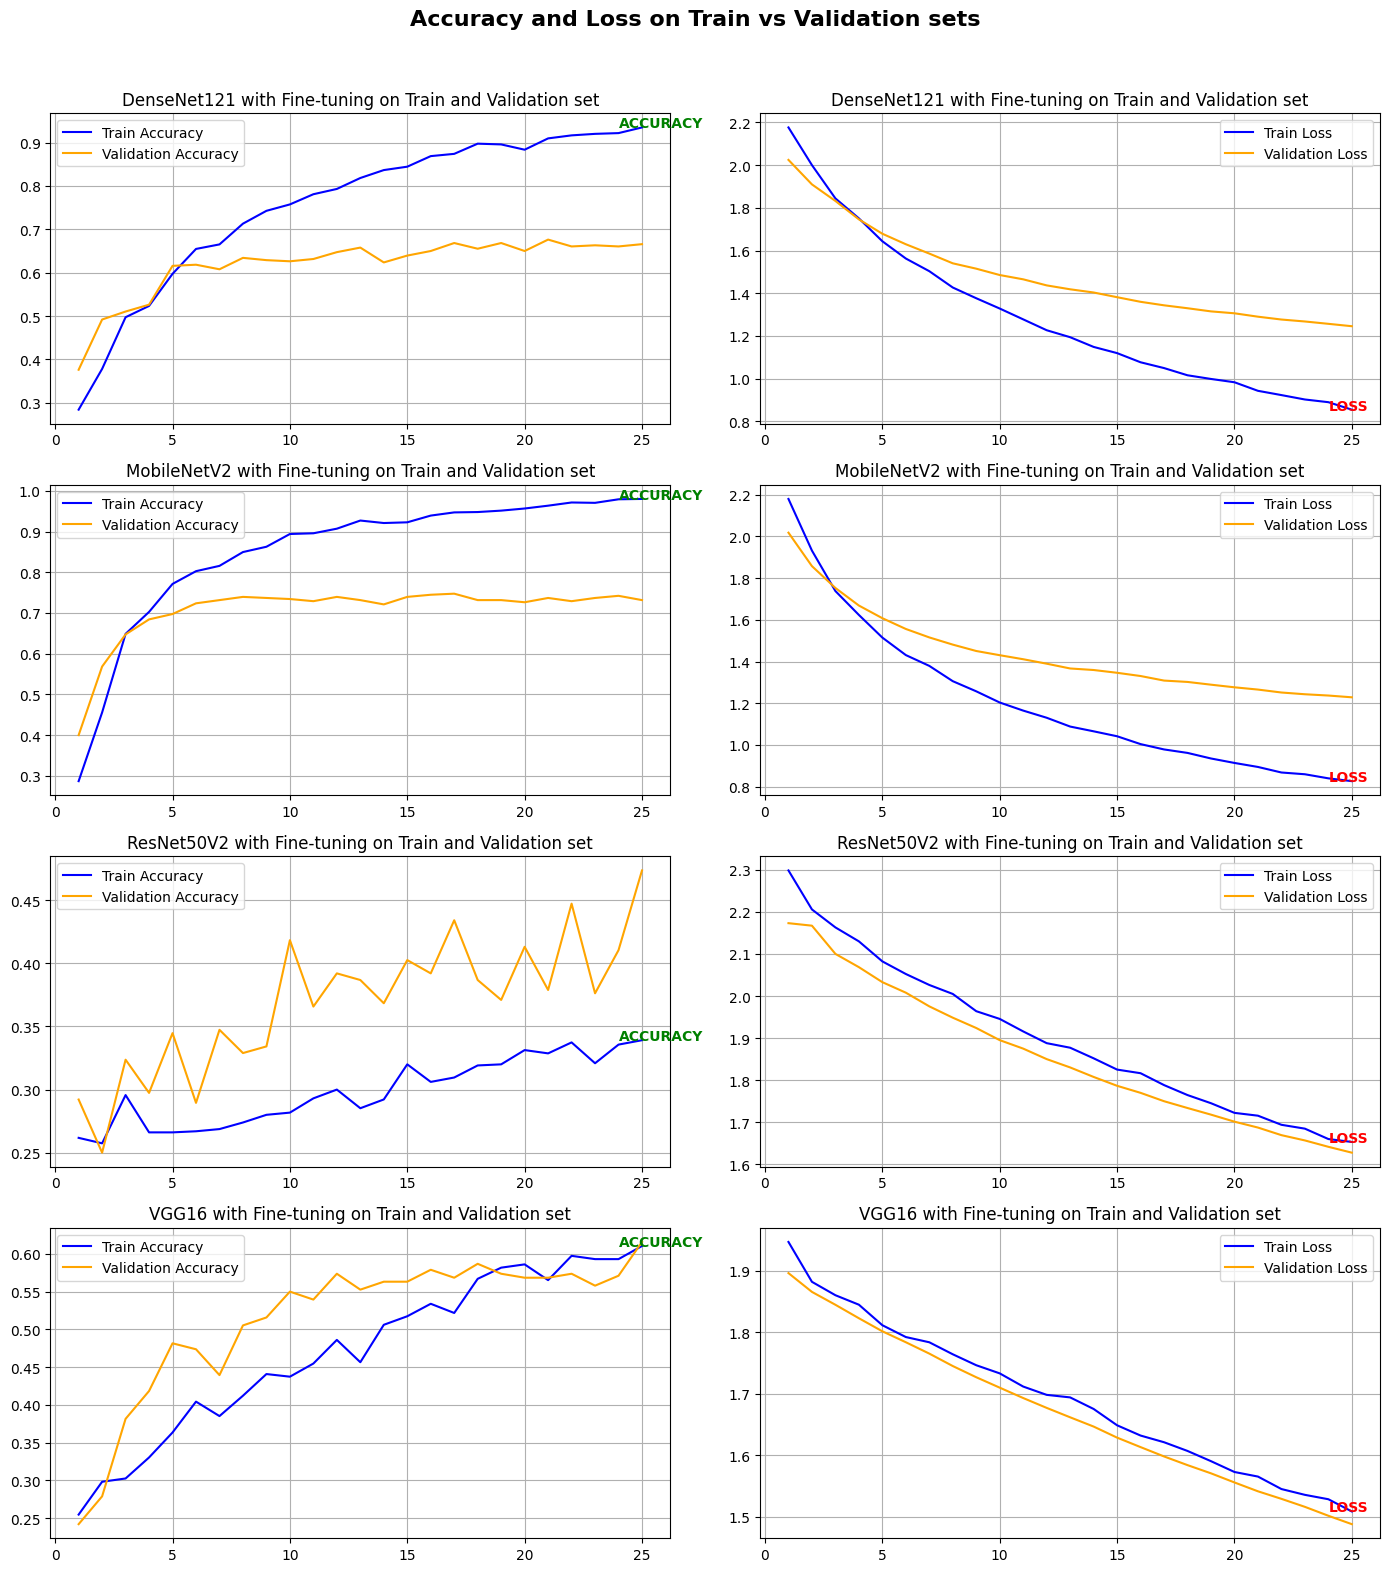

In [ ]:
import matplotlib.pyplot as plt

# ✅ สร้างกราฟ Accuracy & Loss
fig, axes = plt.subplots(4, 2, figsize=(14, 16))  # 4 โมเดล x 2 กราฟ (Accuracy, Loss)
fig.suptitle("Accuracy and Loss on Train vs Validation sets", fontsize=16, fontweight="bold")

# ✅ Map ชื่อโมเดลให้ตรงกับชื่อที่ใช้ใน dictionary
model_titles = {
    "VGG16": "VGG16",
    "ResNet50": "ResNet50V2",
    "MobileNetV2": "MobileNetV2",
    "DenseNet121": "DenseNet121"  # ✅ เพิ่ม EfficientNetB0 เพื่อป้องกัน KeyError
}

# ✅ Loop วาดกราฟแต่ละโมเดล
for i, model_name in enumerate(all_results.keys()):
    runs = all_results[model_name]

    # ✅ ดึงค่า Accuracy และ Loss ของแต่ละ epoch จากทุกการรัน
    train_acc_all = [run["history"]["accuracy"] for run in runs]
    val_acc_all = [run["history"]["val_accuracy"] for run in runs]
    train_loss_all = [run["history"]["loss"] for run in runs]
    val_loss_all = [run["history"]["val_loss"] for run in runs]

    # ✅ คำนวณค่า Mean ของแต่ละ epoch
    train_acc = np.mean(train_acc_all, axis=0)
    val_acc = np.mean(val_acc_all, axis=0)
    train_loss = np.mean(train_loss_all, axis=0)
    val_loss = np.mean(val_loss_all, axis=0)

    epochs = range(1, len(train_acc) + 1)

    # ✅ Plot Accuracy
    axes[i, 0].plot(epochs, train_acc, 'b-', label="Train Accuracy")
    axes[i, 0].plot(epochs, val_acc, 'orange', label="Validation Accuracy")
    axes[i, 0].set_title(f"{model_titles.get(model_name, model_name)} with Fine-tuning on Train and Validation set", fontsize=12)  # ✅ ใช้ .get() แทนเพื่อป้องกัน KeyError
    axes[i, 0].legend()
    axes[i, 0].grid(True)
    axes[i, 0].text(len(epochs)-1, train_acc[-1], "ACCURACY", color="green", fontsize=10, fontweight="bold")

    # ✅ Plot Loss
    axes[i, 1].plot(epochs, train_loss, 'b-', label="Train Loss")
    axes[i, 1].plot(epochs, val_loss, 'orange', label="Validation Loss")
    axes[i, 1].set_title(f"{model_titles.get(model_name, model_name)} with Fine-tuning on Train and Validation set", fontsize=12)  # ✅ ใช้ .get() เช่นกัน
    axes[i, 1].legend()
    axes[i, 1].grid(True)
    axes[i, 1].text(len(epochs)-1, train_loss[-1], "LOSS", color="red", fontsize=10, fontweight="bold")

# ✅ ปรับ layout ให้พอดี
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



🔹 Classification Report: DenseNet121
              precision    recall  f1-score   support

  Basketball       0.76      0.72      0.74        18
      Futsal       0.86      0.90      0.88        20
     Running       0.68      0.85      0.76        20
    Training       0.69      0.50      0.58        18

    accuracy                           0.75        76
   macro avg       0.75      0.74      0.74        76
weighted avg       0.75      0.75      0.74        76


🔹 Classification Report: MobileNetV2
              precision    recall  f1-score   support

  Basketball       0.93      0.78      0.85        18
      Futsal       0.95      0.95      0.95        20
     Running       0.68      0.85      0.76        20
    Training       0.69      0.61      0.65        18

    accuracy                           0.80        76
   macro avg       0.81      0.80      0.80        76
weighted avg       0.81      0.80      0.80        76


🔹 Classification Report: ResNet50V2
              pre

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


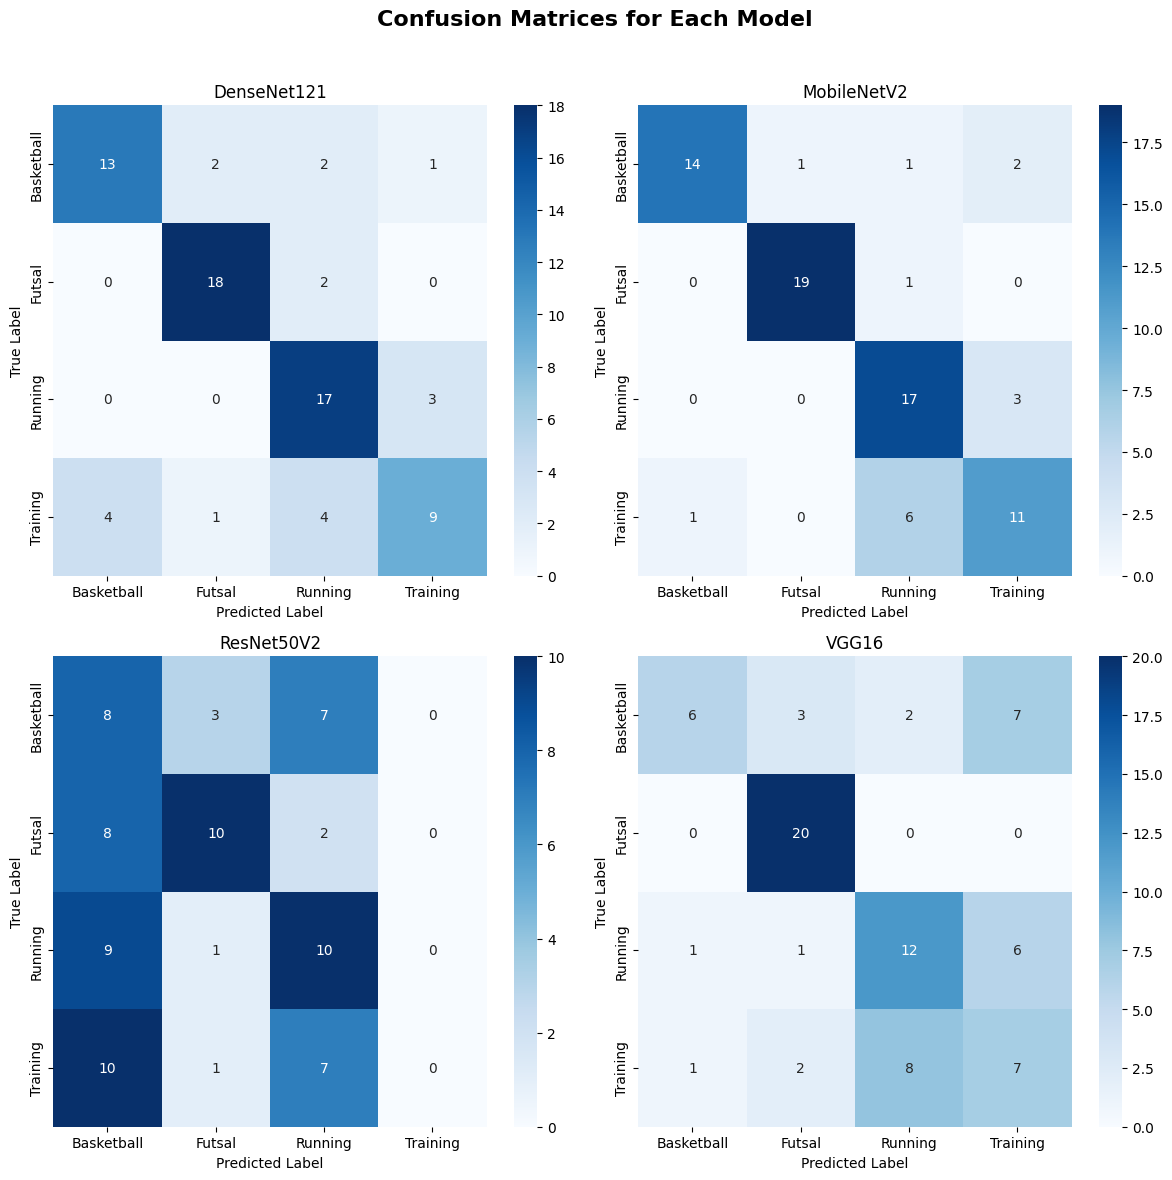

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ ฟังก์ชันสำหรับแสดง Confusion Matrix และ Report ของแต่ละโมเดล
def plot_confusion_matrices(all_res_dict, class_names):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid สำหรับ 4 โมเดล
    fig.suptitle("Confusion Matrices for Each Model", fontsize=16, fontweight="bold")

    model_titles = {
        "DenseNet121": "DenseNet121",
        "MobileNetV2": "MobileNetV2",
        "ResNet50": "ResNet50V2",
        "VGG16": "VGG16"
    }

    for i, (model_name, runs) in enumerate(all_res_dict.items()):
        y_true = runs[0]["y_true"]
        y_pred_classes = runs[0]["y_pred_classes"]

        # ✅ สร้าง Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # ✅ แสดง Classification Report
        print(f"\n🔹 Classification Report: {model_titles.get(model_name, model_name)}")
        print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=2))

        # ✅ พล็อต Confusion Matrix
        ax = axes[i // 2, i % 2]  # เลือกตำแหน่ง subplot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
        ax.set_title(f"{model_titles.get(model_name, model_name)}", fontsize=12)
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ✅ ตั้งชื่อคลาสที่ใช้ใน dataset
class_names = ["Basketball", "Futsal", "Running", "Training"]

# ✅ เรียกใช้ฟังก์ชันเพื่อพล็อต
plot_confusion_matrices(all_results, class_names)


========= Runtime Comparison =========
Pre-training Models with Fine-tuning      GPU  Avg. time per epoch (sec)
                         MobileNetV2 Tesla T4                     1.6615
                            ResNet50 Tesla T4                     1.8929
                               VGG16 Tesla T4                     2.1269
                         DenseNet121 Tesla T4                     2.7639


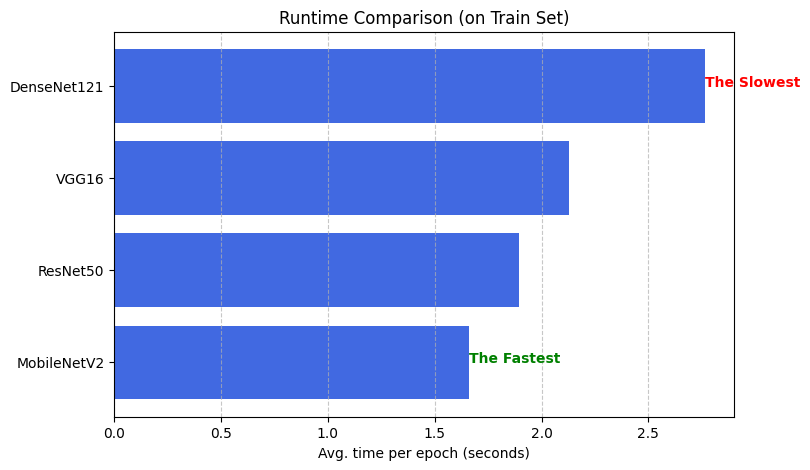

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ ดึงข้อมูลเวลาเฉลี่ยต่อ epoch จาก all_results
runtime_data = []
for model_name, runs in all_results.items():
    avg_epoch_times = [run["avg_epoch_time_sec"] for run in runs]
    runtime_data.append([model_name, "Tesla T4", np.mean(avg_epoch_times)])

# ✅ แปลงข้อมูลเป็น DataFrame
df_runtime = pd.DataFrame(runtime_data, columns=["Pre-training Models with Fine-tuning", "GPU", "Avg. time per epoch (sec)"])
df_runtime = df_runtime.sort_values("Avg. time per epoch (sec)", ascending=True)  # ✅ เรียงลำดับจากเร็ว -> ช้า

# ✅ แสดงผลข้อมูลในรูปแบบตาราง
print("\n========= Runtime Comparison =========")
print(df_runtime.to_string(index=False))

# ✅ สร้างกราฟแท่งแสดงเวลาเฉลี่ยต่อ epoch
plt.figure(figsize=(8, 5))
plt.barh(df_runtime["Pre-training Models with Fine-tuning"], df_runtime["Avg. time per epoch (sec)"], color="royalblue")
plt.xlabel("Avg. time per epoch (seconds)")
plt.title("Runtime Comparison (on Train Set)")

# ✅ ไฮไลท์ fastest/slowest model
fastest_model = df_runtime.iloc[0]["Pre-training Models with Fine-tuning"]
slowest_model = df_runtime.iloc[-1]["Pre-training Models with Fine-tuning"]

plt.text(df_runtime["Avg. time per epoch (sec)"].max(), slowest_model, "The Slowest", color="red", fontweight="bold")
plt.text(df_runtime["Avg. time per epoch (sec)"].min(), fastest_model, "The Fastest", color="green", fontweight="bold")

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

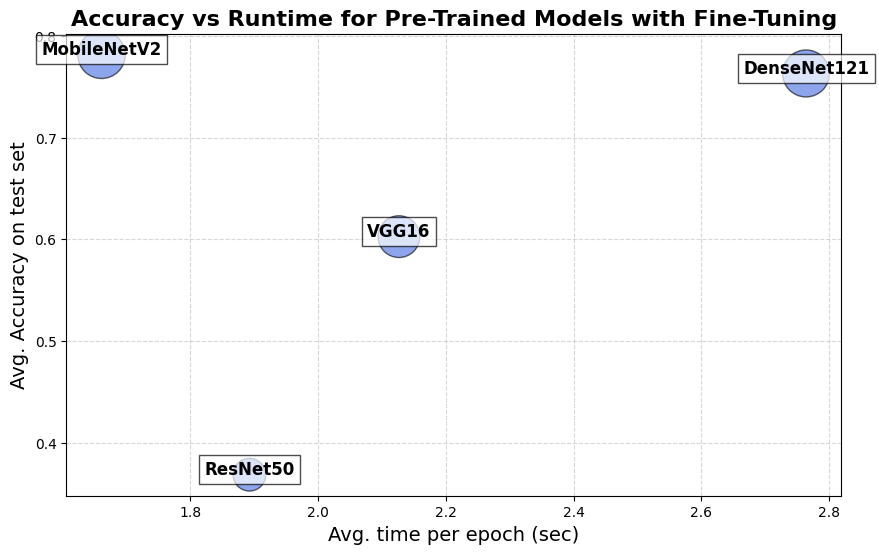

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ ดึงค่าจริงจาก all_results
model_data = []
for model_name, runs in all_results.items():
    accuracies = [run["metrics"]["accuracy"] for run in runs]
    runtimes = [run["avg_epoch_time_sec"] for run in runs]

    # ✅ คำนวณค่าเฉลี่ยของ Accuracy และ Runtime
    avg_acc = np.mean(accuracies)
    avg_runtime = np.mean(runtimes)

    model_data.append([model_name, avg_acc, avg_runtime])

# ✅ แปลงเป็น DataFrame
df_bubble = pd.DataFrame(model_data, columns=["Model", "Accuracy", "Runtime"])

# ✅ Plot Bubble Chart
plt.figure(figsize=(10, 6))

# ขนาดของ Bubble ใช้ค่า Accuracy (เพื่อแสดงขนาดต่างกันชัดขึ้น)
bubble_size = df_bubble["Accuracy"] * 1500

# ✅ สร้างกราฟ Scatter Plot
plt.scatter(df_bubble["Runtime"], df_bubble["Accuracy"], s=bubble_size, color="royalblue", alpha=0.6, edgecolors="black")

# ✅ ใส่ชื่อโมเดลในแต่ละ Bubble (ปรับให้ใหญ่ขึ้นและอ่านง่ายขึ้น)
for i, row in df_bubble.iterrows():
    plt.text(row["Runtime"], row["Accuracy"], row["Model"], ha="center", fontsize=12, fontweight="bold", color="black", bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# ✅ กำหนดค่าแกน
plt.xlabel("Avg. time per epoch (sec)", fontsize=14)
plt.ylabel("Avg. Accuracy on test set", fontsize=14)
plt.title("Accuracy vs Runtime for Pre-Trained Models with Fine-Tuning", fontsize=16, fontweight="bold")

# ✅ เปิด Grid และ Show Plot
plt.grid(alpha=0.5, linestyle="--")
plt.show()

In [ ]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

# ✅ กำหนด Random Seed เพื่อให้ผลลัพธ์สม่ำเสมอ
SEED = 789
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ✅ ตั้งค่า dataset paths
#DATASET_PATH = "/content/dataset"
TEST_PATH = test_path
NUM_CLASSES = 4
NUM_RUNS = 5
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4

# ✅ โหลด Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training', shuffle=True, seed=SEED
)
val_generator = train_datagen.flow_from_directory(
    validation_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation', shuffle=True, seed=SEED
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# ✅ Callback สำหรับจับเวลาในแต่ละ epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.start_time)

# ✅ ฟังก์ชันสร้างโมเดล
def create_model(model_name, num_classes=4, fine_tune=False):
    if model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet", include_top=False)
    elif model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False)
    elif model_name == "DenseNet121":
        base_model = DenseNet121(weights="imagenet", include_top=False)
    elif model_name == "VGG16":
        base_model = VGG16(weights="imagenet", include_top=False)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # ✅ Freeze ทุก Layer (ไม่ให้เรียนรู้ต่อ)
    base_model.trainable = False  # ❌ ไม่ให้ Backbone อัปเดตน้ำหนัก

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.1)(x)
    output = Dense(num_classes, activation="softmax")(x)

    return Model(inputs=base_model.input, outputs=output)

# ✅ เก็บผลลัพธ์
results = {model: {"without_fine_tune": [], "with_fine_tune": []} for model in ["DenseNet121", "MobileNetV2", "ResNet50", "VGG16"]}

# ✅ Training Loop
for model_name in results.keys():
    for run in range(NUM_RUNS):
        print(f"\n===== Training {model_name} (Run {run+1}) WITHOUT Fine-tuning =====")
        tf.keras.backend.clear_session()
        model = create_model(model_name, num_classes=NUM_CLASSES, fine_tune=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

        time_callback = TimeHistory()
        history = model.fit(train_generator, validation_data=val_generator, epochs=NUM_EPOCHS, callbacks=[time_callback], verbose=1)

        # ✅ ทดสอบบน Test Set
        y_pred = model.predict(test_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.classes
        report = classification_report(y_true, y_pred_classes, output_dict=True)

        results[model_name]["without_fine_tune"].append({
            "history": history.history,
            "test_accuracy": report["accuracy"],
            "avg_epoch_time_sec": np.mean(time_callback.epoch_times)
        })

        # ✅ บันทึกโมเดลก่อน Fine-tune
        model.save_weights(f"{model_name}_no_finetune.weights.h5")

        print(f"\n===== Training {model_name} (Run {run+1}) WITH Fine-tuning =====")
        tf.keras.backend.clear_session()
        model = create_model(model_name, num_classes=NUM_CLASSES, fine_tune=True)
        model.load_weights(f"{model_name}_no_finetune.weights.h5")  # โหลด weights ที่เทรนไปแล้ว
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

        time_callback = TimeHistory()
        history = model.fit(train_generator, validation_data=val_generator, epochs=NUM_EPOCHS, callbacks=[time_callback], verbose=1)

        # ✅ ทดสอบอีกครั้งหลัง Fine-tune
        y_pred = model.predict(test_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.classes
        report = classification_report(y_true, y_pred_classes, output_dict=True)

        results[model_name]["with_fine_tune"].append({
            "history": history.history,
            "test_accuracy": report["accuracy"],
            "avg_epoch_time_sec": np.mean(time_callback.epoch_times)
        })

# ✅ บันทึกผลเป็น CSV
df_results = pd.DataFrame()
for model_name, res in results.items():
    for method, runs in res.items():
        acc_mean = np.mean([r["test_accuracy"] for r in runs])
        acc_std = np.std([r["test_accuracy"] for r in runs])
        time_mean = np.mean([r["avg_epoch_time_sec"] for r in runs])
        time_std = np.std([r["avg_epoch_time_sec"] for r in runs])

        df_results = df_results.append({
            "Model": model_name,
            "Method": "Fine-tuned" if method == "with_fine_tune" else "Without Fine-tuning",
            "Test Accuracy (mean ± SD)": f"{acc_mean:.4f} ± {acc_std:.4f}",
            "Avg. time per epoch (sec)": f"{time_mean:.2f} ± {time_std:.2f}"
        }, ignore_index=True)

df_results.to_csv("fine_tuning_comparison.csv", index=False)
print("✅ บันทึกผลเป็น 'fine_tuning_comparison.csv'")


In [ ]:
#######################################################
# SECTION 0: Installation (ถ้ายังไม่ได้ทำ)
#######################################################
# !pip install keras-tuner wandb

#######################################################
# SECTION 1: Import & Global Settings
#######################################################
import os
import random
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import wandb
import shutil  # ← สำหรับลบ tuner เดิม

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

SEED = 789
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#######################################################
# SECTION 2: Prepare Dataset
#######################################################
DATASET_PATH = "/content/dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

#######################################################
# SECTION 3: Define HyperModel for Keras Tuner (MobileNetV2)
#######################################################
def build_model(hp, model_name="MobileNetV2"):
    if model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False)
    elif model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
    elif model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False)
    elif model_name == "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False)
    else:
        raise ValueError("❌ Invalid model name")

    base_model.trainable = False

    l2_reg = hp.Choice("l2_reg", [0.0001, 0.001, 0.01])
    dropout_rate = hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu", kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(4, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

#######################################################
# SECTION 4: Keras Tuner - RandomSearch
#######################################################
# ✅ ลบ tuner เดิมก่อน เพื่อให้ค้นหาชุดใหม่ทุกครั้ง
shutil.rmtree("hyper_tuning", ignore_errors=True)

tuner = kt.RandomSearch(
    lambda hp: build_model(hp, model_name="DenseNet121"),  # ✅ เปลี่ยนชื่อโมเดลตรงนี้ได้
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="hyper_tuning",
    project_name="MobileNetV2_tuning"
)

tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("🔹 Best Hyperparams:")
print(f"l2_reg={best_hp.get('l2_reg')}")
print(f"dropout={best_hp.get('dropout')}")
print(f"learning_rate={best_hp.get('learning_rate')}")

#######################################################
# SECTION 5: Train Best Model + Log to WandB Manually
#######################################################
best_model = tuner.hypermodel.build(best_hp)

# ✅ เริ่ม WandB และบันทึกค่า
wandb.login()
wandb.init(
    project="hyperparameter_tuning_project",
    entity="art-tra-ctw-national-institute-of-development-administration",
    config={
        "l2_reg": best_hp.get('l2_reg'),
        "dropout": best_hp.get('dropout'),
        "learning_rate": best_hp.get('learning_rate'),
        "model_name": "MobileNetV2"
    }
)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

val_acc = max(history.history["val_accuracy"])
wandb.log({"best_val_accuracy": val_acc})
wandb.finish()

print(f"\n✅ Done! Best Val Accuracy from final run: {val_acc:.4f}")
print("✅ Best Hyperparameters Found:")
print(f" - L2 Regularization: {best_hp.get('l2_reg')}")
print(f" - Dropout Rate:      {best_hp.get('dropout')}")
print(f" - Learning Rate:     {best_hp.get('learning_rate')}")


In [ ]:
# 7. Discussion and conclusions

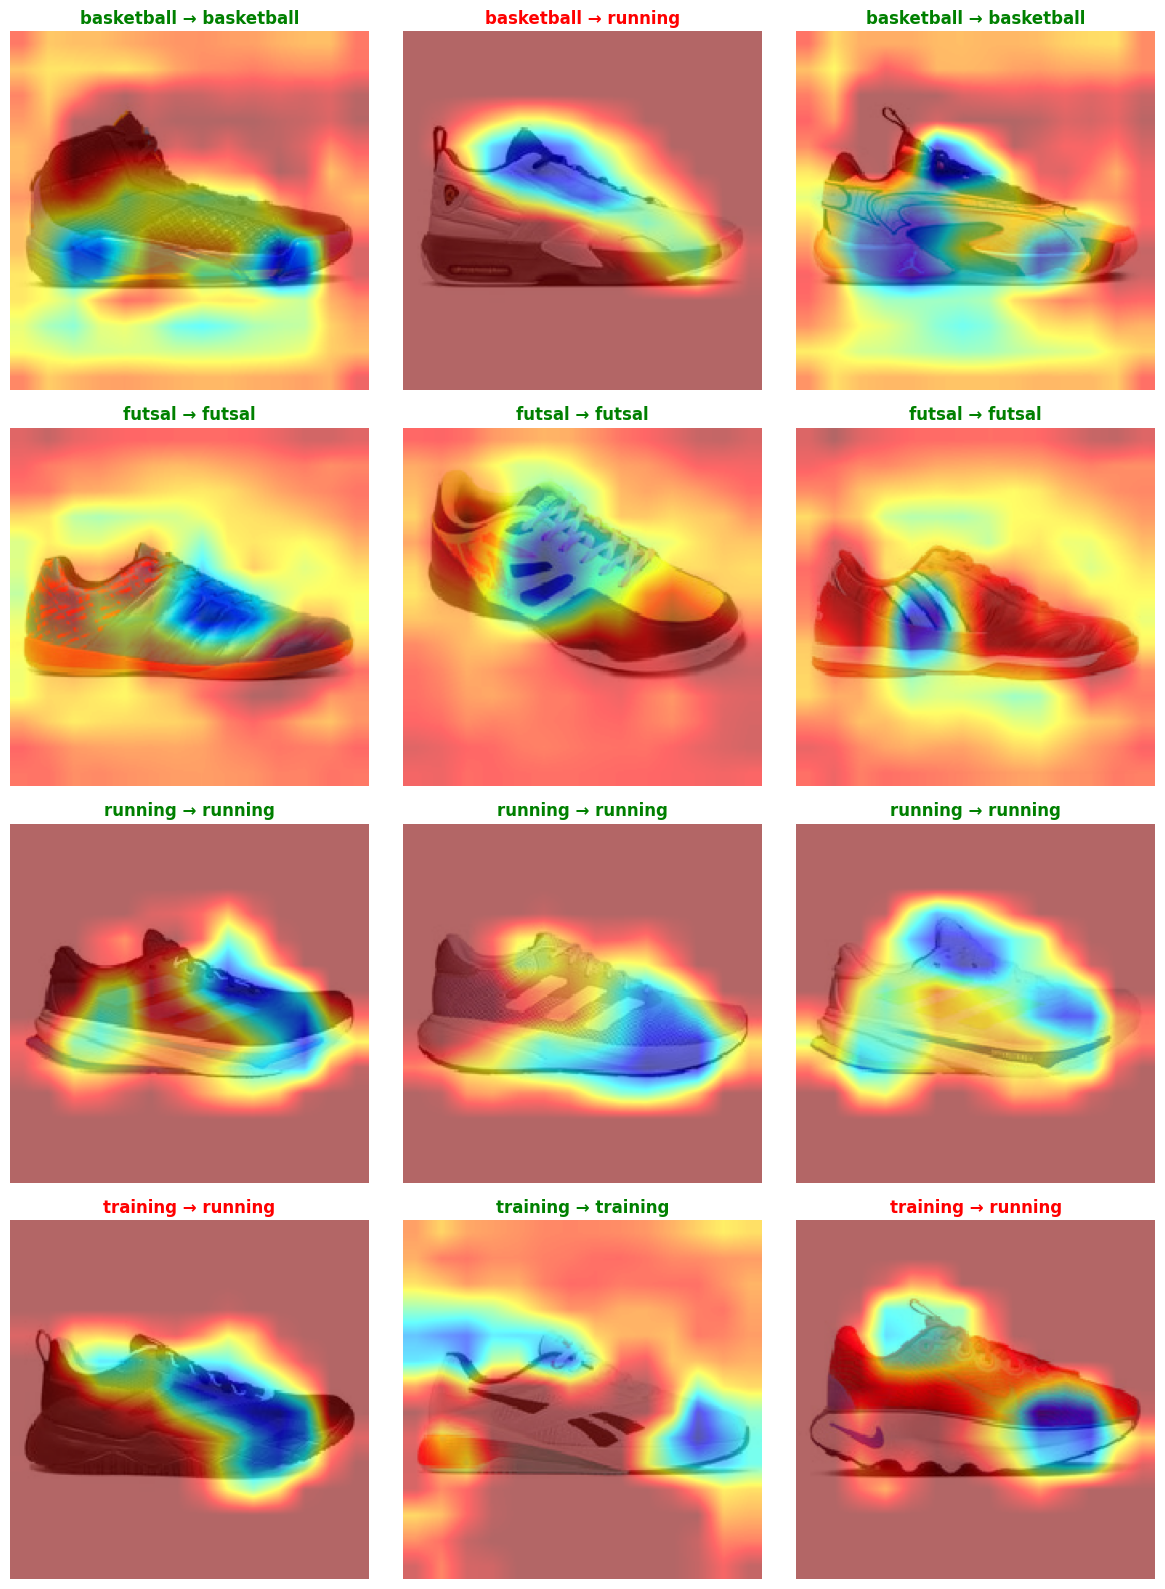

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2

# ✅ ตั้งค่า
test_dir = test_path  # เปลี่ยนเป็นโฟลเดอร์ Test
num_images = 3  # ✅ จำนวนรูปที่ต้องการสุ่มต่อคลาส
class_names = ["basketball", "futsal", "running", "training"]

# ✅ กำหนด Last Conv Layer ของแต่ละโมเดล
last_conv_layer_dict = {
    "VGG16": "block5_conv3",
    "ResNet50": "conv5_block3_out",
    "DenseNet121": "conv5_block16_1_conv",
    "MobileNetV2": "Conv_1"
}

# ✅ ฟังก์ชันสร้าง Grad-CAM
def generate_grad_cam(model, img_path, class_names, last_conv_layer_name, alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # ✅ ดึงโมเดล Backbone
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # ✅ คำนวณ Gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = np.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]

    # ✅ แปลง Heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))  # ❌ เอา .numpy() ออก
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # ✅ ซ้อน Heatmap กับภาพต้นฉบับ
    img_with_heatmap = cv2.addWeighted(np.array(img), alpha, heatmap, 1 - alpha, 0)

    return img_with_heatmap, class_names[predicted_class]

# ✅ แสดงผลหลายภาพ
fig, axes = plt.subplots(len(class_names), num_images, figsize=(num_images * 4, len(class_names) * 4))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(test_dir, class_name)
    image_files = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(num_images, len(image_files)))  # ✅ สุ่มเลือก

    for j, image_file in enumerate(selected_images):
        image_path = os.path.join(class_path, image_file)

        # ✅ ใช้ Grad-CAM
        grad_cam_img, predicted_label = generate_grad_cam(
            model, image_path, class_names, last_conv_layer_dict["VGG16"]
        )

        # ✅ ตรวจสอบว่าโมเดลทำนายถูกหรือผิด
        actual_label = class_name
        correct = predicted_label == actual_label
        color = "green" if correct else "red"
        #marker = "✅" if correct else "❌"

        # ✅ แสดงภาพ Grad-CAM และผลลัพธ์
        axes[i, j].imshow(grad_cam_img)
        #axes[i, j].set_title(f"{actual_label} → {predicted_label} {marker}", color=color, fontsize=12, fontweight="bold")
        axes[i, j].set_title(f"{actual_label} → {predicted_label}", color=color, fontsize=12, fontweight="bold")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# โครงส้ราง Model

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# ✅ ฟังก์ชันสร้างโมเดล
def create_model(base_model_name, num_classes=4, fine_tune_layers=None):
    if base_model_name == "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False)
    elif base_model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False)
    elif base_model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False)
    elif base_model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
    else:
        raise ValueError("Invalid model name")

    # ✅ Freeze ทุก Layer ก่อน
    base_model.trainable = False

    # ✅ เพิ่ม Fully Connected Layer ใหม่
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)  # L2 Regularization
    x = Dropout(0.1)(x)  # Dropout ลด Overfitting
    output = Dense(num_classes, activation="softmax")(x)

    # ✅ รวม Backbone + Fully Connected Layers
    model = Model(inputs=base_model.input, outputs=output, name=f"{base_model_name}_Modified")
    return model


# ✅ แสดงโครงสร้างของทั้ง 4 โมเดล
model_names = ["VGG16", "ResNet50", "MobileNetV2", "DenseNet121"]

for model_name in model_names:
    print(f"\n🔹 Model: {model_name}_Original")
    model_original = tf.keras.applications.__dict__[model_name](weights="imagenet", include_top=True)
    model_original.summary()

    print(f"\n🔹 Model: {model_name}_Modified")
    model_modified = create_model(model_name)
    model_modified.summary()


🔹 Model: VGG16_Original


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)


🔹 Model: VGG16_Modified


Model: "VGG16_Modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


🔹 Model: ResNet50_Original


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)


🔹 Model: ResNet50_Modified


Model: "ResNet50_Modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


🔹 Model: MobileNetV2_Original


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)


🔹 Model: MobileNetV2_Modified


<ipython-input-49-92dbdcb5c8d8>:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False)


Model: "MobileNetV2_Modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


🔹 Model: DenseNet121_Original


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,062,504 (30.76 MB)

 Trainable params: 7,978,856 (30.44 MB)

 Non-trainable params: 83,648 (326.75 KB)


🔹 Model: DenseNet121_Modified


Model: "DenseNet121_Modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, None, None, 3)  │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, None, None, 64) │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, None, None, 64) │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, None, None, 64) │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None,     │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None,     │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None,     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 32) │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, None, None, 96) │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)